# Testing out numerical solver code

## current setup
implicit - explicit solver with an implicit multigrid solver for the diffusion term and RK45 for the reaction term.

## Objectives 

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Constitutive fluorescence
        * Basal protein expression 
        * initial protein concentration set to fixed point of max nutrient
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xs : Expression rate of protein. 


### Model equations
Species:
* $c_p$ : Propagator cells
* $c_s$ : Sender cells
* $n$ : Nutrient
* $a$ : AHL (cell-cell signaling molecule)
* $s$ : Synthase (protein that creates AHL)
* $r$ : Transcriptional repressor (halts production of synthase)

Parameters
* $h_i$ : Hill coefficient
* $k_i$ : Hill function IC50 concentration
* $r_i$ : Species production rate
* $p_i$ : Species degradation or consumption rate
* $D_i$ : Species diffusion coefficient

Inducer-dependent protein production approximation:

$ H(a, n, k) = \frac{a^n}{k^n + a^n}$

$ H_n(a, n, k) = 1 - H(a,n,k) $

Differential equations

$ \partial_t c_p = D_c \Delta c_p + r_c H(n,h_n,90)\,c_p $

$ \partial_t c_s = D_c \Delta c_p + r_c H(n,h_n,90)\,c_s $

$ \partial_t n = D_n \Delta n - p_n H(n,h_n,90)\,(c_p + c_s) $

$ \partial_t a = D_a \Delta a + r_a\,s\,(c_p+c_s)-p_a\,a $

Where $c_s>0$

$ \partial_t s = D_c \Delta s  + (r_s\,c_s - r_c\,s)\,H(n,h_n,90) - p_s\,s$

Where $c_p>0$

$ \partial_t s = D_c \Delta s  + (r_s\,c_p\, H(a,h_s,k_s) H_n(r,h_C,k_C) - r_c\,s)\,H(n,h_n,90) - p_s\,s$

Where both $c_p=0$ and $c_s=0$

$ \partial_t s = D_c \Delta s - p_p\,s$

Where $c_p>0$

$ \partial_t r = D_c \Delta r  + (r_r\,c_p\, H(a,h_r,k_r) - r_c\,r)\,H(n,h_n,90) - p_r\,r$

Where both $c_p=0$ 

$ \partial_t r = D_c \Delta r - p_r\,r$


Inducer-dependent protein production approximation:

$ H(a, n, k) = \frac{a^n}{k^n + a^n}$

Differential equations

$ \partial_t c = D_c \Delta c + r_c H(n,h_n,90)\,c $

$ \partial_t n = D_n \Delta n - k_n H(n,h_n,90)\,c $


In [1]:
# imports
from __future__ import division, print_function

import itertools as itt
import time

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

# %load_ext memory_profiler
# %load_ext line_profiler
import timeit

from IPython.display import HTML

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

In [2]:
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(6)
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,3, figsize=(10,7))
    axs = axs.flatten()
    im_list = [0,0,0,0,0,0]
    
    # Plot cell densities
    ax_ind = 0
    ax = axs[ax_ind]
    indxs = [cp_i, cs_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[ax_ind] = im
    
    # Plot nutrient densities
    ax_ind = 1
    ax = axs[ax_ind]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[ax_ind] = im
    
    # Plot pulser synthase densities
    ax_ind = 2
    ax = axs[ax_ind]
    indxs = [s_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    indxs = [s_i, cs_i]
    v_arr += im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[ax_ind] = im
    
    # Plot ahl conc
    ax_ind = 3
    ax = axs[ax_ind]
    indxs = [a_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('ahl')
    im_list[ax_ind] = im
    
    # Plot pulser repressor densities
    ax_ind = 4
    ax = axs[ax_ind]
    indxs = [r_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('repr')
    im_list[ax_ind] = im
    
    # Plot total cellular protein
    ax_ind = 5
    ax = axs[ax_ind]
    indxs = [s_i, r_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cellular protein')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cp_i, cs_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        indxs = [s_i, cs_i]
        frame_arr += im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)
        
        # Plot ahl
        ax = axs[3]
        indxs = [a_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot repr
        ax = axs[4]
        indxs = [cp_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[4].set_array(frame_arr)

        # Plot cellular protein
        ax = axs[5]
        indxs = [s_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[5].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
#     fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
        A[ind,:,:] += cell_arr
#         A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A



# Try to find out why solvers quit with too_small_step error

In [46]:
import importlib
from omnisim import split_omnisim as oms
oms = importlib.reload(oms)
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,    rc,       rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([5e-8,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, (1.6e-2), 
# Da,   xa,                xs,  xS,
2e-4, (1e-6)/(16/2.25), 250, 200, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0.2, 0.02], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.01

simmer = oms.Simulator(16)
scale = simmer.scale
species = simmer.dims[0]
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [47]:
1/(Da*6*scale**2)

3.255208333333333

In [48]:
def exp_fn(arr, slope):
    out_arr = np.exp(-slope*ndi.morphology.distance_transform_bf(arr==0))
    return out_arr

def new_init_conditions(simmer, n_cp=50, n_cb=0):
    simmer.basedims = np.array([4,4])
    simmer.set_scale(simmer.scale)
    simmer.t_eval = np.linspace(0,11*60*60,200)
    ns, nh, nw = simmer.initial_array.shape
    simmer.initial_array = np.zeros_like(simmer.initial_array)
    simmer.initial_array[n_i,:,:] = 100
    odval = 1e-3*scale**2/4
    for i in range(n_cp):
        rad = np.random.beta(1,1.5,size=(1,))*0.7*simmer.scale
        theta = np.random.uniform(0,2*np.pi,size=(1,))
        x = np.int(nw/2 + np.cos(theta)*rad)
        y = np.int(nh/2 + np.sin(theta)*rad)
        simmer.initial_array[cp_i,y,x] += odval
    rad = np.random.beta(1,1.5,size=(1,))*0.7*simmer.scale
    theta = np.random.uniform(0,2*np.pi,size=(1,))
    x = np.int(nw/2 + np.cos(theta)*rad)
    y = np.int(nh/2 + np.sin(theta)*rad)
    simmer.initial_array[cs_i,y,x] = odval
    simmer.initial_array[cp_i,y,x] = 0
    # Apply exponential slope. progression rate should be 
    simmer.atol.shape = simmer.initial_array.shape
#     for c_i in [cp_i, cs_i]:
#         arr = simmer.initial_array[c_i,:,:]
#         simmer.initial_array[c_i,:,:] = (scale**2)*(exp_fn(arr, (scale)*rc*400))/2e3
#         simmer.atol[c_i,...] = 1e-
#     simmer.atol.shape = np.prod(simmer.atol.shape)


In [49]:
new_init_conditions(simmer)

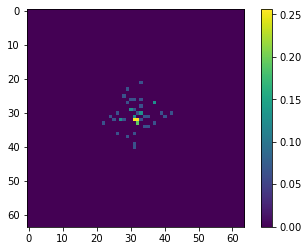

In [50]:
simmer.initial_array.shape = simmer.dims[:-1]
initial_array = simmer.initial_array.copy()
plt.imshow(simmer.initial_array[cp_i,...]-0*simmer.initial_array[cs_i,...],interpolation='none')
plt.colorbar()

In [51]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_2d
cn_gmres_2d = importlib.reload(cn_gmres_2d)
# impexp = cn_gmres_2d.CNMGRK(simmer, 0, 2*60, first_step=5, rk_step=5e-2)

In [ ]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
for loop_i in np.arange(20):
    ns, nh, nw, _ = simmer.dims
    ys = []
    ts = []
    for dt in [3]:#[5,2,1,0.5,0.1]:
        new_init_conditions(simmer)
        simmer.set_p0(p0)
        simmer.initial_array = initial_array.copy()
        impexp = cn_gmres_2d.CNMGRK(simmer, 0, 2*60, first_step=dt, rk_step=dt/4)
        n_loops = np.int(15*3600/dt)
        rtime = time.time()
        for i in np.arange(n_loops):
            status, msg = impexp._step_impl()
            if status==False:
                print(msg)
                break
            if i%20:
                continue
            else:
                ys.append(impexp.y.copy())
                ts.append(i*dt)
            if i%1000:
                continue
            else:
                print("iteration:{} dt:{}".format(i,dt))
                print(dt*i/(time.time() - rtime))

        rtime = time.time() - rtime
    #     err_arr = impexp.y
    #     err_arr = err_arr.reshape((species,nh,nw))
    #     for i in np.arange(species):
    #         plt.figure()
    #         plt.imshow(err_arr[i,:,:])
    #         plt.title((dt, i, rtime))
    #     b = cnmg.cn_rhsb_wrxn(x)
    # #     cnmg.w_cycle(x,b,0)
    #     out = splinalg.gmres(A, b, x)
    # #     x = out[0]
    #     if np.mod(i,n_loops/10)==0:
    #         x = impexp.y.copy()
    #         print(i)
    #         print(impexp.cnmg_solver.dt)
    #         x.shape = (ns,nh,nw)
    #         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
    #         x.shape = ns*nh*nw
    species, nh, nw, dx = simmer.dims
    ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]
    ys_stack = np.concatenate(ys_reshaped,axis=0)
    skimage.io.imsave('./worker_outputs/smallpads_it{:0d}.tif'.format(loop_i),ys_stack,plugin='tifffile')
    np.save('./worker_outputs/smallpads_sa_it{:0d}_tvc.npy'.format(loop_i), np.array(ts))
    print('./worker_outputs/smallpads_it{:0d}.tif'.format(loop_i))
    

iteration:0 dt:3
0.0
iteration:1000 dt:3
157.5310851580217
iteration:2000 dt:3
156.49402964820834
iteration:3000 dt:3
157.71447915361736
iteration:4000 dt:3
158.17447404458997
iteration:5000 dt:3
158.90752531189915
iteration:6000 dt:3
159.30195403450054
iteration:7000 dt:3
159.08438622111333
iteration:8000 dt:3
159.05869033204246
iteration:9000 dt:3
158.62490226120192
iteration:10000 dt:3
158.44830518506936
iteration:11000 dt:3
158.54215911452903
iteration:12000 dt:3
158.6349785915401
iteration:13000 dt:3
158.35028690852744
iteration:14000 dt:3
158.3047837196562
iteration:15000 dt:3
158.37431713326137
iteration:16000 dt:3
158.3845916140885
iteration:17000 dt:3
158.4874198820285
./worker_outputs/smallpads_it0.tif
iteration:0 dt:3
0.0
iteration:1000 dt:3
158.56384783757434
iteration:2000 dt:3
158.3695965704228
iteration:3000 dt:3
158.17570467373275
iteration:4000 dt:3
157.5825147808608
iteration:5000 dt:3
157.5414517332836
iteration:6000 dt:3
157.72427445934628
iteration:7000 dt:3
157.95

In [10]:
species, nh, nw, dx = simmer.dims
ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]

In [11]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [12]:
movie_obj = write_movie(ys_stack, np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

In [ ]:
# Define parameter values to sample
xs = 0
# Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
p0=np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])
od0 = 0.01

simmer = oms.Simulator(16)
scale = simmer.scale
species = simmer.dims[0]
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [ ]:
new_init_conditions(simmer)

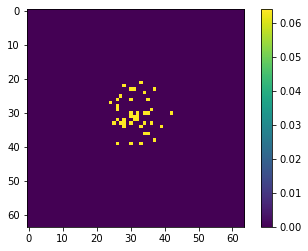

In [41]:
simmer.initial_array.shape = simmer.dims[:-1]
initial_array = simmer.initial_array.copy()
plt.imshow(simmer.initial_array[cp_i,...]-0*simmer.initial_array[cs_i,...],interpolation='none')
plt.colorbar()

In [ ]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
for loop_i in np.arange(20):
    ns, nh, nw, _ = simmer.dims
    ys = []
    ts = []
    for dt in [3]:#[5,2,1,0.5,0.1]:
        new_init_conditions(simmer)
        simmer.set_p0(p0)
        simmer.initial_array = initial_array.copy()
        impexp = cn_gmres_2d.CNMGRK(simmer, 0, 2*60, first_step=dt, rk_step=dt/4)
        n_loops = np.int(15*3600/dt)
        rtime = time.time()
        for i in np.arange(n_loops):
            status, msg = impexp._step_impl()
            if status==False:
                print(msg)
                break
            if i%20:
                continue
            else:
                ys.append(impexp.y.copy())
                ts.append(i*dt)
            if i%1000:
                continue
            else:
                print("iteration:{} dt:{}".format(i,dt))
                print(dt*i/(time.time() - rtime))

        rtime = time.time() - rtime
    #     err_arr = impexp.y
    #     err_arr = err_arr.reshape((species,nh,nw))
    #     for i in np.arange(species):
    #         plt.figure()
    #         plt.imshow(err_arr[i,:,:])
    #         plt.title((dt, i, rtime))
    #     b = cnmg.cn_rhsb_wrxn(x)
    # #     cnmg.w_cycle(x,b,0)
    #     out = splinalg.gmres(A, b, x)
    # #     x = out[0]
    #     if np.mod(i,n_loops/10)==0:
    #         x = impexp.y.copy()
    #         print(i)
    #         print(impexp.cnmg_solver.dt)
    #         x.shape = (ns,nh,nw)
    #         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
    #         x.shape = ns*nh*nw
    species, nh, nw, dx = simmer.dims
    ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]
    ys_stack = np.concatenate(ys_reshaped,axis=0)
    skimage.io.imsave('./worker_outputs/smallpads_sr_it{:0d}.tif'.format(loop_i),ys_stack,plugin='tifffile')
    np.save('./worker_outputs/smallpads_it{:0d}_tvc.npy'.format(loop_i), np.array(ts))
    print('./worker_outputs/smallpads_sr_it{:0d}.tif'.format(loop_i))

In [44]:
species, nh, nw, dx = simmer.dims
ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]

In [45]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [46]:
movie_obj = write_movie(ys_stack, np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

In [43]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
ns, nh, nw, _ = simmer.dims

ys = []
ts = []
for dt in [0.9]:#[5,2,1,0.5,0.1]:
    simmer.set_p0(p0)
    simmer.initial_array = initial_array.copy()
    impexp = cn_gmres_2d.CNMGRK(simmer, 0, 2*60, first_step=dt, rk_step=dt/4)
    n_loops = np.int(20000)
    rtime = time.time()
    for i in np.arange(n_loops):
        status, msg = impexp._step_impl()
        if status==False:
            print(msg)
            break
        if i%20:
            continue
        else:
            ys.append(impexp.y.copy())
            ts.append(i*dt)
        if i%1000:
            continue
        else:
            print("iteration:{} dt:{}".format(i,dt))
            print(dt*i/(time.time() - rtime))

    rtime = time.time() - rtime
#     err_arr = impexp.y
#     err_arr = err_arr.reshape((species,nh,nw))
#     for i in np.arange(species):
#         plt.figure()
#         plt.imshow(err_arr[i,:,:])
#         plt.title((dt, i, rtime))
#     b = cnmg.cn_rhsb_wrxn(x)
# #     cnmg.w_cycle(x,b,0)
#     out = splinalg.gmres(A, b, x)
# #     x = out[0]
#     if np.mod(i,n_loops/10)==0:
#         x = impexp.y.copy()
#         print(i)
#         print(impexp.cnmg_solver.dt)
#         x.shape = (ns,nh,nw)
#         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
#         x.shape = ns*nh*nw

iteration:0 dt:0.9
0.0
iteration:200 dt:0.9
41.35603474045152
iteration:400 dt:0.9
40.90236233137944
iteration:600 dt:0.9
40.50082366949535
iteration:800 dt:0.9
40.357556941642024
iteration:1000 dt:0.9
40.25047531271988
iteration:1200 dt:0.9
40.16342290357313
iteration:1400 dt:0.9
40.09601241477842
iteration:1600 dt:0.9
40.03007021708252
iteration:1800 dt:0.9
39.99897877039187
